In [1]:
print "Modifications to Classify.py from Caffe Framework to make visualizations of each layer easier."
print "Please see LICENSE reproduced with the directory."

Modifications to Classify.py from Caffe Framework to make visualizations of each layer easier.
Please see LICENSE reproduced with the directory.


In [2]:
print "Select an HTTP URL for image"

Select an HTTP URL for image


In [3]:
from ipywidgets import widgets
from IPython.display import Javascript, display, Image
import Image
inputURL = widgets.Text()
inputURL

In [5]:
def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    #print inputURL.value

button = widgets.Button(description="Submit for run:")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

In [6]:
import numpy as np

modelLocation="/home/gsingaraju/Desktop/MachineLearning/caffe.new/caffe/"
workingDirectory="/tmp/"
caffe_root = '/home/gsingaraju/Desktop/MachineLearning/caffe.new/caffe/'

#selected the imagenet model
prototxtFile=modelLocation+"models/bvlc_reference_caffenet/deploy.prototxt"
modelFile=modelLocation+"models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
meanFile=modelLocation+"python/caffe/imagenet/ilsvrc_2012_mean.npy"

In [7]:
import urllib
urllib.urlretrieve(inputURL.value, workingDirectory+'photo.jpg')

('/tmp/photo.jpg', <httplib.HTTPMessage instance at 0x7f0f64ca6e18>)

Retrieved Image.


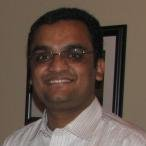

In [8]:
from IPython.display import Image
img=Image(filename=workingDirectory+'photo.jpg')
print "Retrieved Image."
img

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

import sys
sys.path.append(caffe_root + 'python')


import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

caffe.set_mode_gpu()


net = caffe.Classifier(prototxtFile, modelFile, mean=np.load(meanFile).mean(1).mean(1),
                                 channel_swap=(2, 1, 0),raw_scale=255, image_dims=(256, 256))
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(meanFile).mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Predicted class is #906.


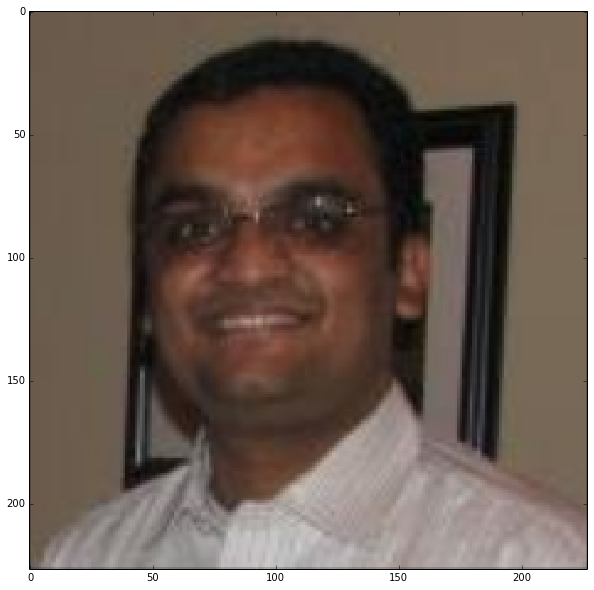

In [10]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(workingDirectory+'photo.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]), interpolation='nearest', aspect='auto')

In [11]:
convLayers=[]
innerProductLayers=[]
for layerName,v in net.params.items():
    layer = net.layers[list(net._layer_names).index(layerName)]
    if layer.type == "Convolution":
        convLayers.append(layerName)
    else:
        innerProductLayers.append(layerName)

In [12]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

In [13]:
dropdownbox = widgets.Dropdown(
    options=convLayers,
    description='Select Image:',
)

display(dropdownbox)

In [27]:
button = widgets.Button(description="Conv Layer")
button.on_click(run_all)
display(button)
print "Conv layer: " + dropdownbox.value

<IPython.core.display.Javascript object>

Conv layer: conv5


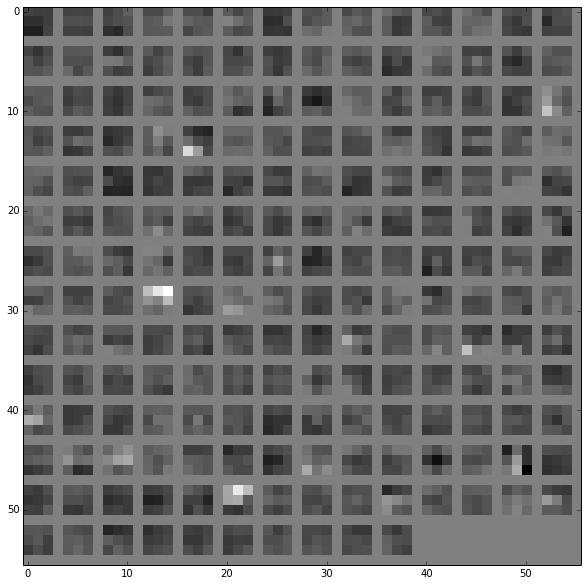

In [28]:
# the parameters are a list of [weights, biases]
filters = net.params[dropdownbox.value][0].data[0,:]
vis_square(filters, padval=0.5)

The first layer output, `conv1` (rectified responses of the filters)

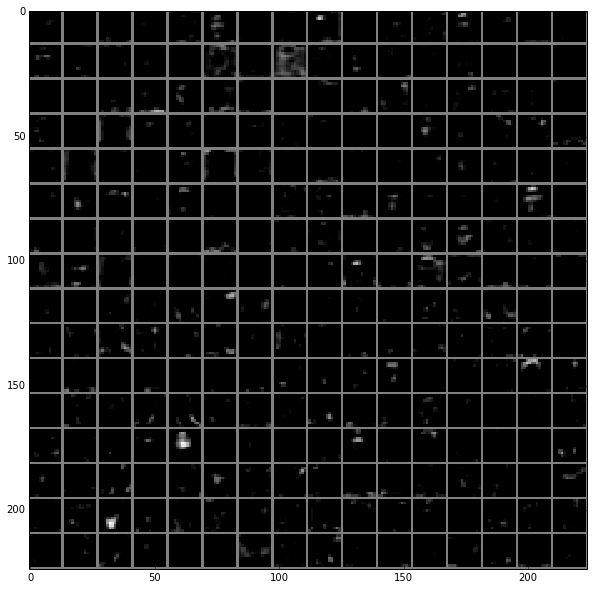

In [29]:
feat = net.blobs[dropdownbox.value].data[0, :]
vis_square(feat, padval=0.5)

In [30]:
dropdownbox3 = widgets.Dropdown(
    options=innerProductLayers,
    description='Select InnerProduct:',
)

display(dropdownbox3)

In [40]:
button3 = widgets.Button(description="InnerProduct Layer")
button3.on_click(run_all)
display(button3)
print "FC layer: " + dropdownbox3.value

<IPython.core.display.Javascript object>

FC layer: fc8


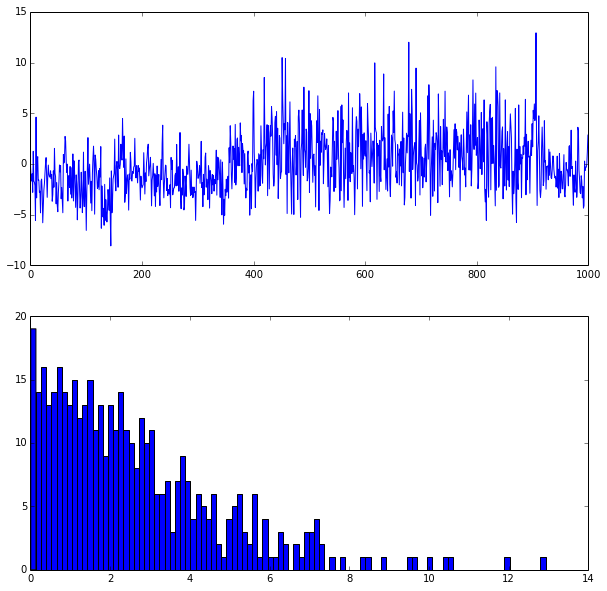

In [41]:
feat = net.blobs[dropdownbox3.value].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

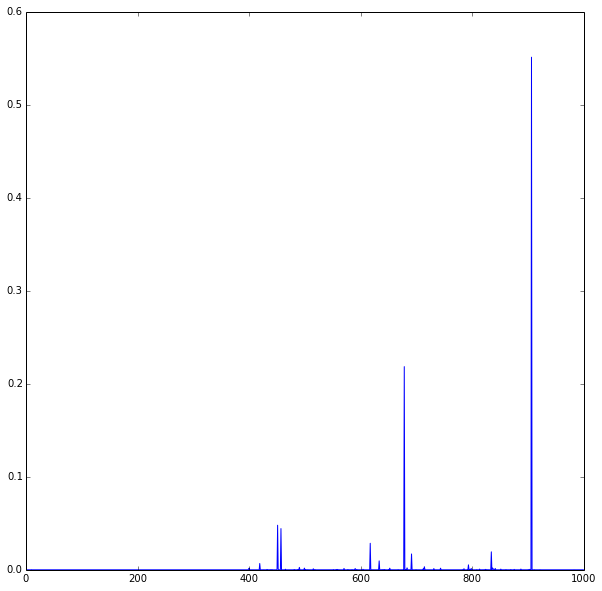

In [42]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat )